

```
# This is formatted as code
```

# data process


In [7]:
!pip install -q pypdf2  faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.9 MB/s eta 0:00:00


In [20]:
import os
import requests
from PyPDF2 import PdfReader

# Define PDF URLs
pdf_urls = {
    "Travelite_India": "https://www.traveliteindia.com/uimages/downloads/45.pdf",
    # "Air_India_Security": "https://rde.airindia.com/content/dam/air-india/pdfs/security-regulations-dangerous-goods-restricted-items.pdf",
    "Air_India_Express_Fees": "https://airindiaexpress-uat.adobecqms.net/content/dam/air-asia/mandatory-disclosure/AIX-FeesandCharges-12-OCT-23.pdf",
    "IndiGo_ZED_Policy": "https://cargo.goindigo.in/content/dam/indigov2/slt/ZEDPolicy.pdf",
    "Alliance_Air_Baggage": "https://plone.allianceair.in/allianceair/en/assets/policy/baggage-policy.pdf"
}

# Create local directory
os.makedirs("pdfs", exist_ok=True)

# Download PDFs
for name, url in pdf_urls.items():
    path = f"pdfs/{name}.pdf"
    if not os.path.exists(path):
        response = requests.get(url)
        print(f"✅ Downloading: {name}")
        with open(path, 'wb') as f:
            f.write(response.content)
        print(f"✅ Downloaded: {name}")


✅ Downloading: Air_India_Express_Fees
✅ Downloaded: Air_India_Express_Fees
✅ Downloading: IndiGo_ZED_Policy
✅ Downloaded: IndiGo_ZED_Policy
✅ Downloading: Alliance_Air_Baggage
✅ Downloaded: Alliance_Air_Baggage


In [21]:
import re

# Extract text from PDFs
def extract_text_from_pdf(path):
    reader = PdfReader(path)
    return "\n".join([page.extract_text() or "" for page in reader.pages])

# Clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text.strip()

# Chunk text into 500–800 character windows
def chunk_text(text, max_len=800):
    chunks = []
    text = clean_text(text)
    while len(text) > max_len:
        split = text[:max_len].rfind('.')
        if split == -1:
            split = max_len
        chunks.append(text[:split+1].strip())
        text = text[split+1:].strip()
    if text:
        chunks.append(text)
    return chunks

# Process all documents
all_chunks = []
metadata = []

for name in pdf_urls:
    pdf_path = f"pdfs/{name}.pdf"
    raw_text = extract_text_from_pdf(pdf_path)
    chunks = chunk_text(raw_text)
    all_chunks.extend(chunks)
    metadata.extend([{"source": name, "chunk_id": i} for i in range(len(chunks))])

print(f"✅ Processed {len(all_chunks)} text chunks.")


✅ Processed 197 text chunks.


In [22]:
from sentence_transformers import SentenceTransformer

# Use lightweight model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(all_chunks, show_progress_bar=True)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
import faiss
import pickle

# Build index
dimension = embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

# Save FAISS index
faiss.write_index(index, "faiss_index.index")

# Save metadata
with open("metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

# Save all_chunks -  Sry this was missing!
with open("all_chunks.pkl", "wb") as f:
    pickle.dump(all_chunks, f)

print("✅ FAISS index, metadata, and all_chunks saved.")


✅ FAISS index and metadata saved.


In [26]:
# Search the index
query = "What air india express fees?"
query_embedding = model.encode([query])
distances, indices = index.search(query_embedding, k=5)

for idx in indices[0]:
    print(f"[{metadata[idx]['source']}] {all_chunks[idx]}")
    print("-" * 80)


[Air_India_Express_Fees] Max Up to 30004,000Add on Type Xtra Pack Xperience Pack Xecutive Pack Xpress Prime SeatsExtra Leg Room Seats - 50% Discount Included Standard SeatsAll Standard Seats Included Included Included Meals Hot Included Included Included Meals Sandwich Included Included Included Xtra Carry On Bag +3 Kg extra cabin bag - - Included Xpress AheadPriority Check -in - Included Included Priority Baggage - Priority Boarding - Price -Domestic  700  1,000  1,700 Price  International  700  1,200  2,750Air India Express Fees & Charges -Domestic Advantage Add -on Packs Pre-book Cabin Baggage Fee 7kg +3 Kgs +5 Kgs   Free 1050 1750"For flight duration less than 75 minutes, only Lite bites will be available instead of Hot Meals.
--------------------------------------------------------------------------------
[Alliance_Air_Baggage] 25038 INR** **Charges may be increase or decrease based on the rate of currency conversion . Prepaid Baggage Charges (Alliance Air) Upto 5Kg Above 5Kg to 1

In [27]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib openpyxl xgboost

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Load the dataset
df = pd.read_excel('Data_Train.xlsx')
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (10683, 11)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None

First 5 rows:
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   

In [30]:
# EDA - Missing values
print("\n=== MISSING VALUES ANALYSIS ===")
print(df.isnull().sum())
print("\nMissing values percentage:")
print((df.isnull().sum() / len(df)) * 100)

# EDA - Basic statistics
print("\n=== BASIC STATISTICS ===")
print(df.describe())


=== MISSING VALUES ANALYSIS ===
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Missing values percentage:
Airline            0.000000
Date_of_Journey    0.000000
Source             0.000000
Destination        0.000000
Route              0.009361
Dep_Time           0.000000
Arrival_Time       0.000000
Duration           0.000000
Total_Stops        0.009361
Additional_Info    0.000000
Price              0.000000
dtype: float64

=== BASIC STATISTICS ===
              Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000


In [31]:
# Handle missing values
df = df.dropna()
print(f"\nDataset shape after removing missing values: {df.shape}")



Dataset shape after removing missing values: (10682, 11)


In [32]:
# Feature Engineering - Date and Time processing
def extract_datetime_features(df):
    # Date_of_Journey
    df['Journey_day'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.day
    df['Journey_month'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.month
    df['Journey_year'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.year

    # Departure Time
    df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute

    # Arrival Time
    df['Arrival_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arrival_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute

    # Duration processing
    duration = df['Duration'].str.split(' ')
    df['Duration_hours'] = 0
    df['Duration_mins'] = 0

    for i, dur in enumerate(duration):
        if len(dur) == 2:
            df.loc[i, 'Duration_hours'] = int(dur[0][:-1])
            df.loc[i, 'Duration_mins'] = int(dur[1][:-1])
        elif 'h' in dur[0]:
            df.loc[i, 'Duration_hours'] = int(dur[0][:-1])
        else:
            df.loc[i, 'Duration_mins'] = int(dur[0][:-1])

    df['Total_Duration_mins'] = df['Duration_hours'] * 60 + df['Duration_mins']

    return df



In [33]:
df = extract_datetime_features(df)


In [34]:
# Handle Total_Stops
df['Total_Stops'] = df['Total_Stops'].map({
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
})

In [35]:

# Remove unnecessary columns
df = df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Duration_hours', 'Duration_mins'], axis=1)



=== FEATURE CORRELATIONS ===


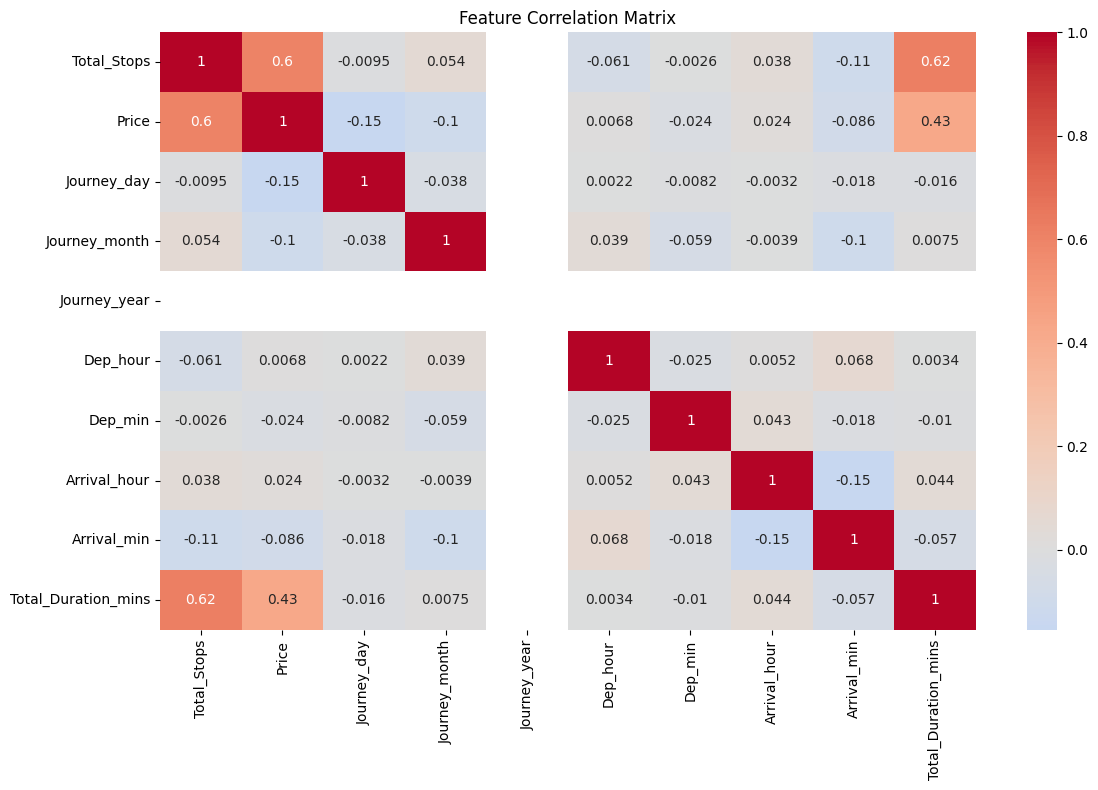

In [36]:
print("\n=== FEATURE CORRELATIONS ===")
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


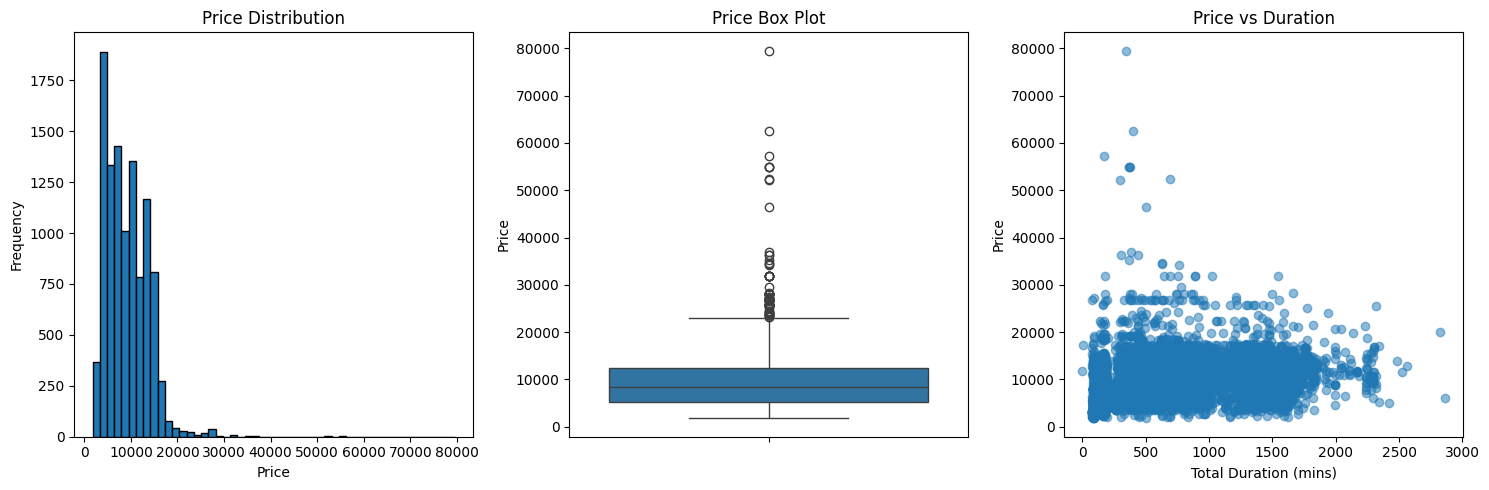

In [37]:

# EDA - Price distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Price'], bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Price'])
plt.title('Price Box Plot')

plt.subplot(1, 3, 3)
plt.scatter(df['Total_Duration_mins'], df['Price'], alpha=0.5)
plt.xlabel('Total Duration (mins)')
plt.ylabel('Price')
plt.title('Price vs Duration')

plt.tight_layout()
plt.show()


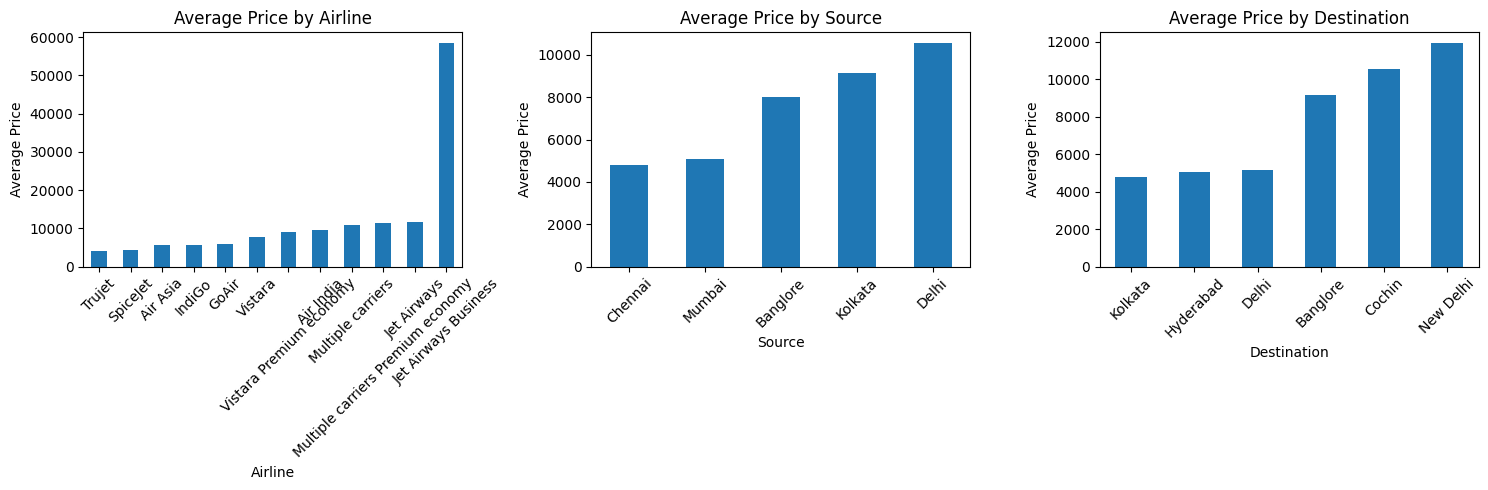

In [38]:

# EDA - Categorical features analysis
categorical_features = ['Airline', 'Source', 'Destination']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    df.groupby(feature)['Price'].mean().sort_values().plot(kind='bar')
    plt.title(f'Average Price by {feature}')
    plt.xticks(rotation=45)
    plt.ylabel('Average Price')

plt.tight_layout()
plt.show()


In [43]:
# Data Preprocessing
print("\n=== DATA PREPROCESSING ===")

# Separate features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Identify categorical and numerical columns
categorical_features = ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']
numerical_features = [col for col in X.columns if col not in categorical_features and X[col].dtype != 'object']

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


=== DATA PREPROCESSING ===
Categorical features: ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']
Numerical features: ['Total_Stops', 'Journey_day', 'Journey_month', 'Journey_year', 'Dep_hour', 'Dep_min', 'Arrival_hour', 'Arrival_min', 'Total_Duration_mins']


In [50]:
# Create preprocessing pipeline
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

In [51]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (8546, 14)
Test set size: (2137, 14)


In [52]:

# Create and train the model pipeline
print("\n=== MODEL TRAINING ===")

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])





=== MODEL TRAINING ===


In [53]:
# Create and train the model pipeline
print("\n=== MODEL TRAINING ===")

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Drop rows with NaN values in y_train
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]


=== MODEL TRAINING ===


In [55]:
# Make predictions
rf_pipeline.fit(X_train, y_train) # Fit the pipeline with training data
y_pred_rf = rf_pipeline.predict(X_test)

In [56]:

# Evaluate Random Forest
print("=== RANDOM FOREST RESULTS ===")
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {rf_mae:.2f}")
print(f"Random Forest - RMSE: {rf_rmse:.2f}")
print(f"Random Forest - R²: {rf_r2:.4f}")


=== RANDOM FOREST RESULTS ===
Random Forest - MAE: 589.57
Random Forest - RMSE: 1341.63
Random Forest - R²: 0.9137


In [57]:
# Train XGBoost model
try:
    import xgboost as xgb

    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)

    print("\n=== XGBOOST RESULTS ===")
    xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    xgb_r2 = r2_score(y_test, y_pred_xgb)

    print(f"XGBoost - MAE: {xgb_mae:.2f}")
    print(f"XGBoost - RMSE: {xgb_rmse:.2f}")
    print(f"XGBoost - R²: {xgb_r2:.4f}")

    # Choose best model
    if xgb_r2 > rf_r2:
        best_model = xgb_pipeline
        best_model_name = "XGBoost"
        print(f"\nBest Model: {best_model_name}")
    else:
        best_model = rf_pipeline
        best_model_name = "Random Forest"
        print(f"\nBest Model: {best_model_name}")

except ImportError:
    print("\nXGBoost not installed. Using Random Forest as final model.")
    best_model = rf_pipeline
    best_model_name = "Random Forest"



=== XGBOOST RESULTS ===
XGBoost - MAE: 819.59
XGBoost - RMSE: 1413.13
XGBoost - R²: 0.9043

Best Model: Random Forest


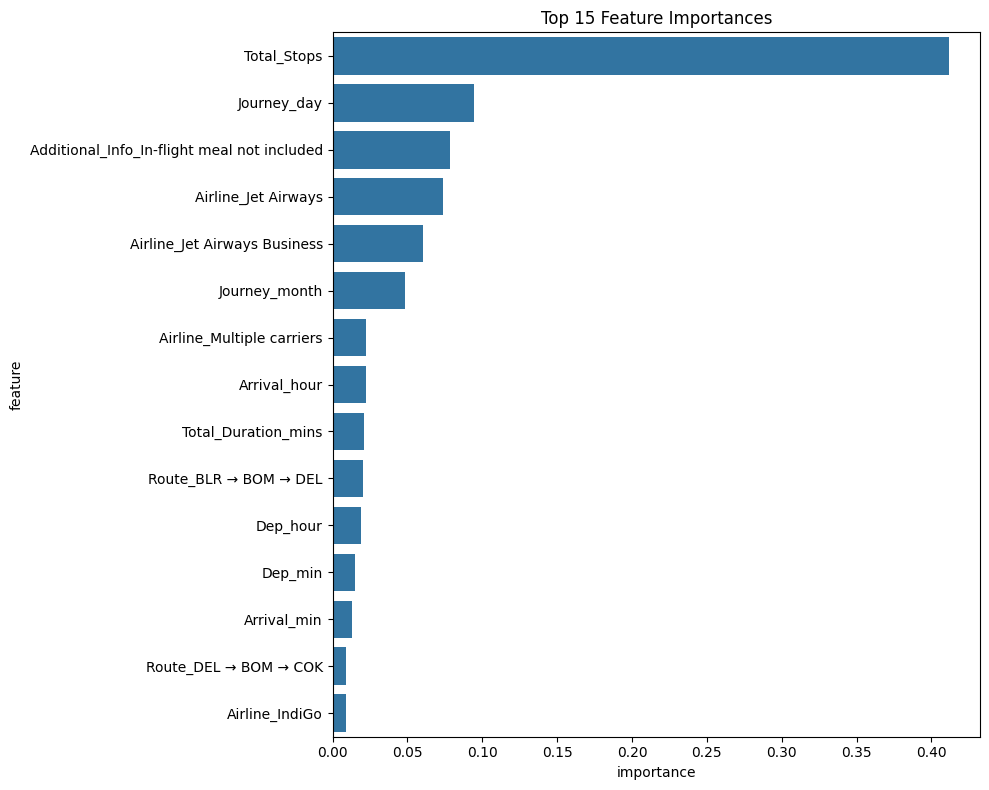


Top 10 Most Important Features:
                                         feature  importance
0                                    Total_Stops    0.411820
1                                    Journey_day    0.094772
157  Additional_Info_In-flight meal not included    0.078233
12                           Airline_Jet Airways    0.073874
13                  Airline_Jet Airways Business    0.060197
2                                  Journey_month    0.048368
14                     Airline_Multiple carriers    0.022348
6                                   Arrival_hour    0.022084
8                            Total_Duration_mins    0.021076
33                         Route_BLR → BOM → DEL    0.020203


In [58]:

# Feature importance (for Random Forest)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (numerical_features +
                    list(best_model.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .get_feature_names_out(categorical_features)))

    importances = best_model.named_steps['regressor'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(15), y='feature', x='importance')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))


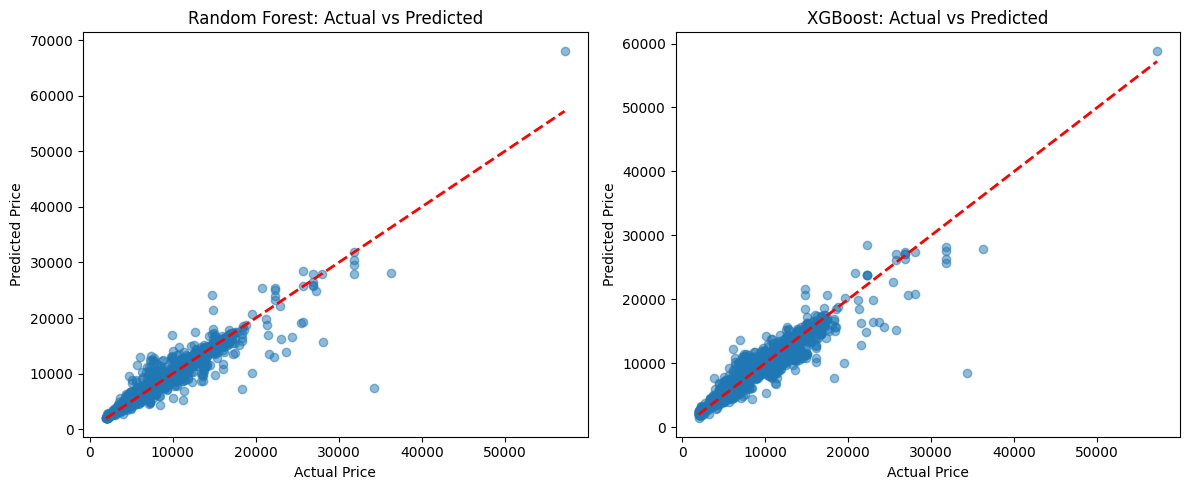

In [59]:

# Model evaluation visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')

if 'y_pred_xgb' in locals():
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_xgb, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('XGBoost: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [60]:

# Save the model pipeline
print("\n=== SAVING MODEL ===")
model_filename = 'flight_price_prediction_pipeline.joblib'
joblib.dump(best_model, model_filename)
print(f"Model pipeline saved as: {model_filename}")

# Save feature names for future use
joblib.dump(feature_names, 'feature_names.joblib')
print("Feature names saved as: feature_names.joblib")



=== SAVING MODEL ===
Model pipeline saved as: flight_price_prediction_pipeline.joblib
Feature names saved as: feature_names.joblib


In [62]:
#Example of loading and using the saved model
print("\n=== MODEL LOADING EXAMPLE ===")
loaded_model = joblib.load(model_filename)
loaded_feature_names = joblib.load('feature_names.joblib')

# Make a sample prediction
sample_prediction = loaded_model.predict(X_test.iloc[:5])
print("Sample predictions from loaded model:")
for i, pred in enumerate(sample_prediction):
    print(f"Sample {i+1}: Predicted Price = ₹{pred:.2f}, Actual Price = ₹{y_test.iloc[i]:.2f}")

print(f"\nModel training completed! Best model: {best_model_name}")
print(f"Model saved as: {model_filename}")


=== MODEL LOADING EXAMPLE ===
Sample predictions from loaded model:
Sample 1: Predicted Price = ₹10944.25, Actual Price = ₹10844.00
Sample 2: Predicted Price = ₹5732.16, Actual Price = ₹4959.00
Sample 3: Predicted Price = ₹14792.04, Actual Price = ₹14781.00
Sample 4: Predicted Price = ₹3707.75, Actual Price = ₹3858.00
Sample 5: Predicted Price = ₹12898.00, Actual Price = ₹12898.00

Model training completed! Best model: Random Forest
Model saved as: flight_price_prediction_pipeline.joblib


In [63]:
from google.colab import files
files.download('/content/flight_price_prediction_pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>